In [1]:
from tensorflow.keras import backend as K
K.clear_session()

import tensorflow as tf
tf.config.experimental.list_physical_devices()

/software/generic/JupyterHub/conda-env-20191018-0834/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/software/generic/JupyterHub/conda-env-20191018-0834/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/software/generic/JupyterHub/conda-env-20191018-0834/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tifffile import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from sklearn.model_selection import train_test_split

import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import os

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/My Drive/Colab Notebooks/martin/fluo'
  # augmented: data_path += '/aug'
except:
  import os
  from pathlib import Path
  here = os.getcwd()  # os.path.abspath(os.path.dirname(__file__))
  data_path = str(Path(here).joinpath('../data/toy/fluo'))

print('getting data from {}, folders there are: {}'.format(data_path, list(os.walk(data_path))[0][1]))

getting data from /home/h4/stfo194b/rp/martin/attila/unet/../data/toy/fluo, folders there are: ['.ipynb_checkpoints', 'masks', 'images']


In [5]:
image_size = (128, 128)  # original is 1100 x 700
input_shape = (*image_size, 1)
best_model_weights = 'model.h5'

In [11]:
def get_data(imgs_path, masks_path, image_size):
    """ Get and resize train images and masks """
    
    def load_tiff(f, normalize=False):
        img = imread(f)
        img = img_to_array(img)
        img = resize(img, image_size)
        
        if normalize:  # normalize in [0, 1]
            m = min(img.ravel())
            M = max(img.ravel())
            r = M - m
            img = (img - m) / r  # todo very slow

        return img
    
    def load_image(name):
        f = str(Path(imgs_path).joinpath(name))
        return load_tiff(f, normalize=True)
    
    def load_mask(name):
        name = name.replace('img_', 'mask_')  # respective mask
        f = str(Path(masks_path).joinpath(name))
        return load_tiff(f, normalize=True)

    list_imgs = next(os.walk(imgs_path))[2]

    X = np.zeros((len(list_imgs), *input_shape), dtype=np.float32)
    y = np.zeros((len(list_imgs), *input_shape), dtype=np.float32)
    
    for i, img_name in enumerate(list_imgs):
        X[i, ..., 0] = load_image(img_name).squeeze()
        y[i] = load_mask(img_name)

    return X, y

# get data
X, y = get_data(data_path + '/images', data_path + '/masks', image_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)  # split train and test

print('found {} samples: {} training, {} validation'.format(len(X), len(X_train), len(X_valid)))

found 92 samples: 82 training, 10 validation


74

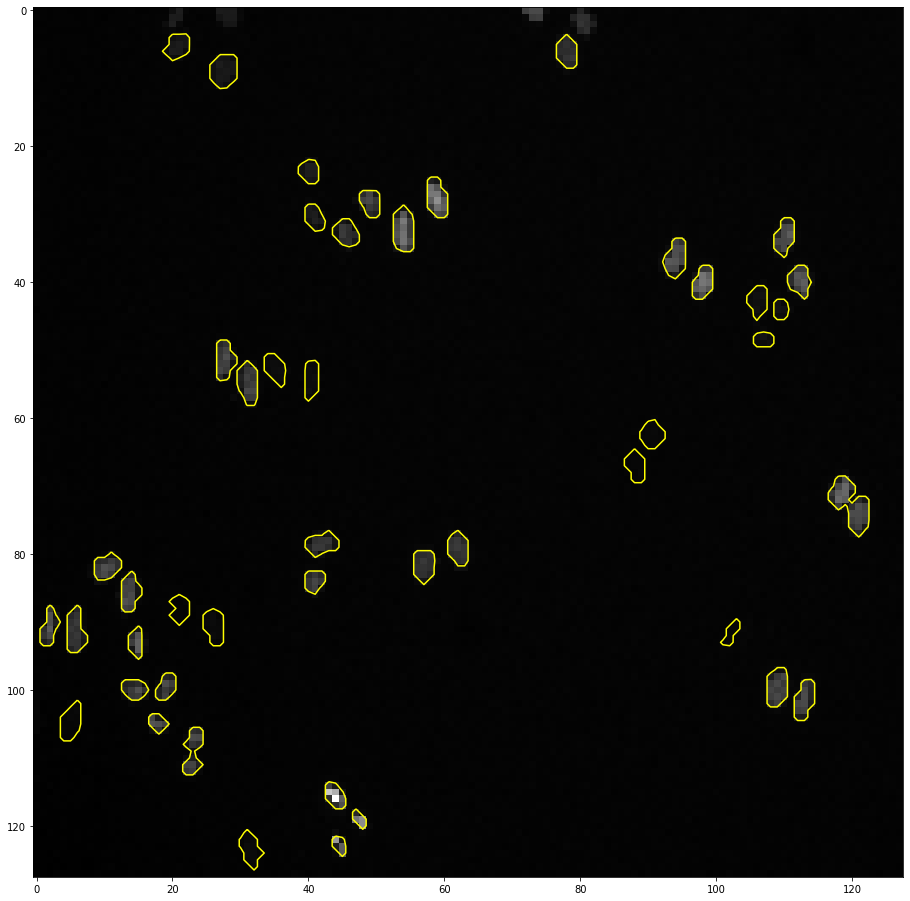

In [12]:
def plot_train_sample(X, y, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    plt.figure(figsize=(16, 16))
    plt.imshow(X[ix, ..., 0], cmap='gray')
    plt.contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    
    return ix

def plot_pred_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[0].set_title('image + mask')

    ax[1].imshow(preds[ix].squeeze(), cmap='gray')
    ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[1].set_title('predicted + original mask')

    return ix

def plot_results(results):
    plt.figure(figsize=(24, 8))

    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

    plt.xlabel("epochs")
    plt.ylabel("log loss")
    plt.legend()

plot_train_sample(X_train, y_train)  # check if training data looks all right

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def get_unet(input_img, n_filters, dropout=0.5, batchnorm=True):
    pooling = MaxPooling2D

    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = pooling((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = pooling((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = pooling((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = pooling((2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    # u path
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

input_img = Input(input_shape)
model = get_unet(input_img, 64, dropout=0.3, batchnorm=True)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
# model.summary()

W1028 11:05:23.444820 47871888413952 deprecation.py:506] From /software/generic/JupyterHub/conda-env-20191018-0834/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1028 11:05:24.231054 47871888413952 deprecation.py:323] From /software/generic/JupyterHub/conda-env-20191018-0834/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 82 samples, validate on 10 samples
Epoch 1/30
80/82 [============================>.] - ETA: 0s - loss: 0.3489 - acc: 0.9142
Epoch 00001: loss improved from inf to 0.34464, saving model to model.h5
82/82 [==============================] - 24s 291ms/sample - loss: 0.3446 - acc: 0.9158 - val_loss: 1.7153 - val_acc: 0.3557
Epoch 2/30
80/82 [============================>.] - ETA: 0s - loss: 0.1353 - acc: 0.9779
Epoch 00002: loss improved from 0.34464 to 0.13483, saving model to model.h5
82/82 [==============================] - 6s 78ms/sample - loss: 0.1348 - acc: 0.9778 - val_loss: 0.3197 - val_acc: 0.9618
Epoch 3/30
80/82 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9812
Epoch 00003: loss improved from 0.13483 to 0.09017, saving model to model.h5
82/82 [==============================] - 6s 77ms/sample - loss: 0.0902 - acc: 0.9812 - val_loss: 0.1602 - val_acc: 0.9728
Epoch 4/30
80/82 [============================>.] - ETA: 0s - loss: 0.0685 - acc: 0.9828
Epoch

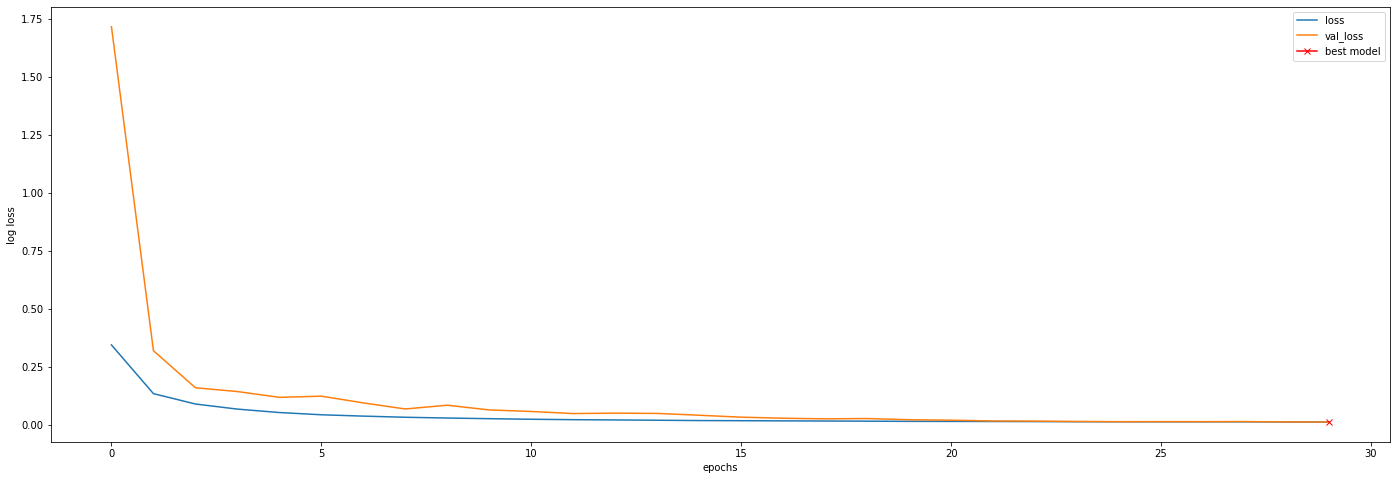

In [14]:
verbose = 1
batch_size = 4
epochs = 30

callbacks = [
    EarlyStopping(patience=10, verbose=verbose),
    ReduceLROnPlateau(factor=1e-1, patience=3, min_lr=1e-5, verbose=verbose),
    ModelCheckpoint(best_model_weights, monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
]
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_valid, y_valid))

plot_results(results)

model.load_weights(best_model_weights)  # load best model
model.evaluate(X_valid, y_valid, verbose=verbose)  # evaluate on validation set

preds_train = model.predict(X_train, verbose=verbose)  # predict
preds_val = model.predict(X_valid, verbose=verbose)

3

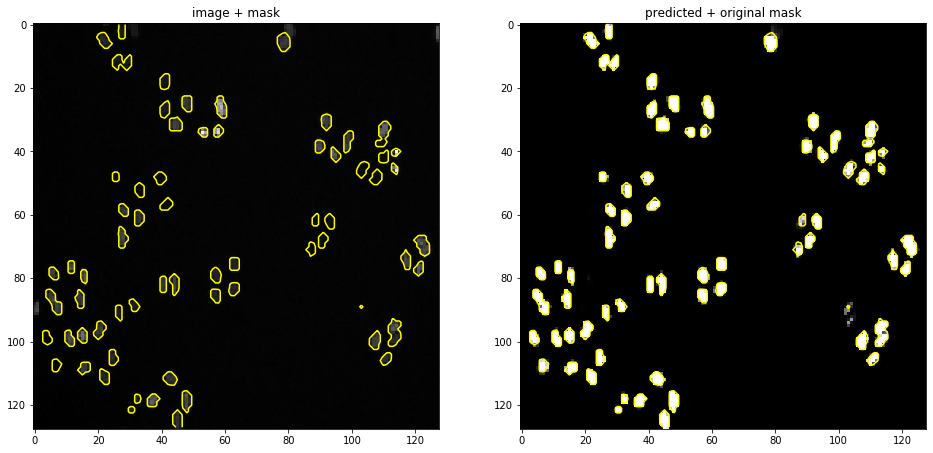

In [15]:
# plot_pred_sample(X_train, y_train, preds_train)  # predictions on training data
plot_pred_sample(X_valid, y_valid, preds_val)  # predictions on test data